In [1]:
import sys
sys.path.append('../py')
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib import cm
from matplotlib.colors import ListedColormap
import yaml

from plot.results import plot_brier_skill, plot_weights

## Brier weights

In [2]:
# load matrix of weights
path_hits = Path('../results/hits')
weights = xr.Dataset({str(rp): xr.open_dataarray(path_hits / f'{rp}/COMB/weighing/weights_brier.nc') for rp in [2, 5, 20]})

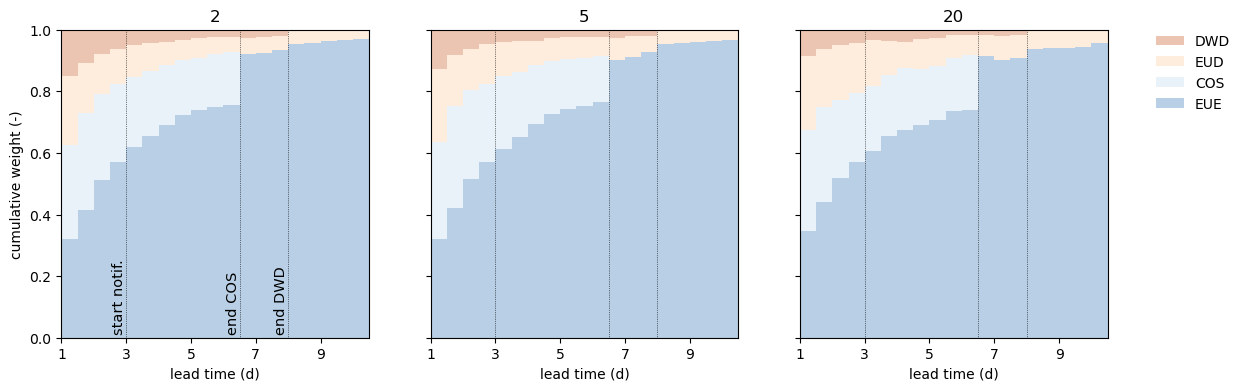

In [3]:
# define a colour map
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0.2, .95, 128)),
                       bottom(np.linspace(.05, .8, 128))))
BuOr = ListedColormap(newcolors, name='BlueOrange')

# heatmap of weights
plot_weights(weights.reindex(model=['EUE', 'COS', 'EUD', 'DWD']),
             cmap=BuOr,
             save=None)#f'{path_weights}/brier_weights_vs_return_period.jpg')

## Hydrograph

In [4]:
models = {'COS': {'members': 20, 'leadtimes': 22},
          'DWD': {'members': 1, 'leadtimes': 28},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}

In [5]:
with open('../conf/config_COMB_all_leadtimes.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [99]:
stn = 109
start, end = datetime(2021, 7, 1), datetime(2021, 7, 31) #datetime(2021, 7, 1, 0), datetime(2021, 7, 31)

In [100]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# reporting points
path_stations = cfg.get('paths', {}).get('output', {}).get('reporting_points', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

# minimum performance required from the reporting points

In [101]:
path_dis_reanalysis = Path(cfg.get('discharge', {}).get('output', {}).get('reanalysis', f'../data/discharge/reanalysis/'))
path_dis_forecast = Path(cfg.get('discharge', {}).get('input', {}).get('forecast', f'../data/discharge/forecast/'))

In [102]:
stations = pd.read_parquet(file_stations)
stations = pd.DataFrame(stations.loc[stn]).transpose()
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

thresholds = stations[['rl1.5', 'rl2', 'rl5', 'rl20', 'rl100']].squeeze()

no. stations:			1


In [103]:
# load timeseries of discharge reanalysis
Qobs = xr.open_dataarray(path_dis_reanalysis / f'{stn:04}.nc').to_pandas()

# observed events
obs = (Qobs > thresholds.rl5).astype(int).loc[start + timedelta(days=10):end]
print('no. observed events:\t{0}'.format((np.diff(obs) == 1).sum()))
obs = xr.DataArray(obs, coords={'datetime': obs.index})

no. observed events:	1


In [104]:
# return period
rp = '5'

weights_6h = xr.DataArray(coords={'model': ['COS', 'DWD', 'EUD', 'EUE'], 'leadtime': range(6, 241, 6)},
                          dims=['model', 'leadtime'])

for lt in weights_6h.leadtime.data:
    if lt in weights[rp].leadtime.data:
        weights_6h.loc[{'leadtime': lt}] = weights[rp].sel(leadtime=lt)
    else:
        weights_6h.loc[{'leadtime': lt}] = weights[rp].sel(leadtime=6 + lt)

In [105]:
forecast = '2021071412'
yyyy = forecast[:4]
mm = forecast[4:6]

# dis = pd.DataFrame(dtype=float)
dis_model = {}
for model in models:
    # open dataaray with dicharge data
    file = path_dis_forecast / model / f'{yyyy}/{mm}/{model}{forecast}.nc'
    da = xr.open_dataarray(file).isel(time=slice(1, None))
    da['time'] = da.time - np.timedelta64(6, 'h')
    # limit the forecast to its maximum leadtime
    if len(da.time) > models[model]['leadtimes']:
        da = da.isel(time=slice(None, models[model]['leadtimes']))
    if model == 'EUE':
        time = da.time.data.copy()
    da = da.rename({'time': 'leadtime'})
    da['leadtime'] = range(6, models[model]['leadtimes'] * 6 + 1, 6)
    df = da.sel(stations=str(stn)).to_pandas()
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df).transpose()
    df.index = [f'{model}-{i:02}' for i, idx in enumerate(df.index)]
    dis_model[model] = df
    # dis = pd.concat((dis, df), axis=0)

dis = pd.concat([df for model, df in dis_model.items()], axis=0)

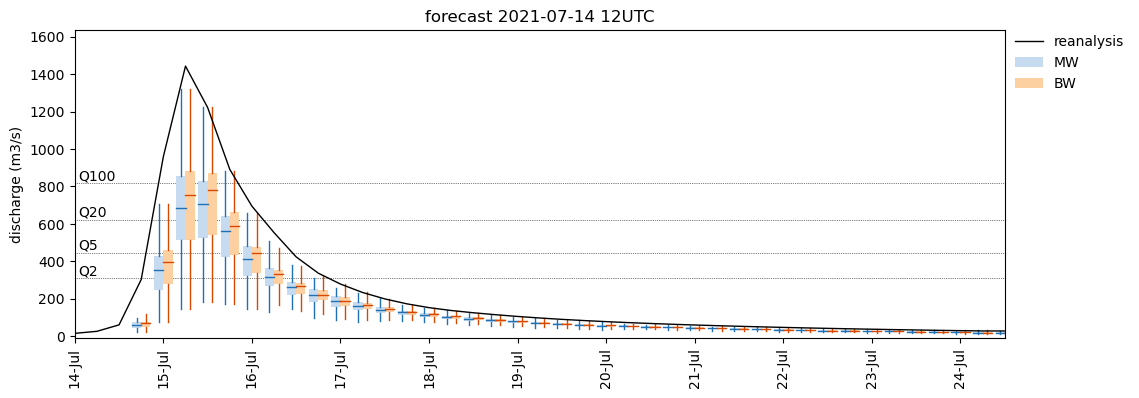

In [134]:
Qobs = Qobs.loc[start:end]

fc = datetime.strptime(forecast, '%Y%m%d%H')



st, en = fc - timedelta(days=.5), fc + timedelta(days=10)
ymax = thresholds['rl100'] * 2

# combination = 'Brier weighted'

fig, ax = plt.subplots(figsize=(12, 4))
width = .105

# reanalysis
ax.plot(Qobs, c='k', lw=1, zorder=5, label='reanalysis')

# forecasts
for lt in dis.columns:
    
    # MEMBER WEIGHTED
    cbox1 = plt.get_cmap('Blues')(0.25)
    cline1 = plt.get_cmap('Blues')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt - 1.25))
    ax.boxplot(dis[lt].dropna(),
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox1, 'edgecolor': 'none'},
               medianprops={'color': cline1},
               whiskerprops={'color': cline1},
               flierprops={'markersize': 0})
        
    # BRIER WEIGHTED
    
    # discharge values
    q = dis[lt].dropna().sort_values()
    members = q.shape[0]
    # print(lt, members)

    # weights
    w = weights_6h.sel(leadtime=lt).to_pandas()
    w = pd.Series({model: v / models[model]['members'] for model, v in w.items()})
    
    assert np.isclose(np.nansum([v * models[model]['members'] for model, v in w.items()]), 1., rtol=1e-3), 'The sum of weights is not 1'
    
    # cumulative probability of non-exceedance
    p = pd.Series([w[idx.split('-')[0]] for idx in q.index], index=q.index).cumsum()
    
    assert np.isclose(p.max(), 1., rtol=1e-3), 'The cumulative non-exceedance probability is not 1'
    
    # discharge quantiles
    idx = [(p - x).abs().idxmin() for x in [.25, .5, .75]]
    quantiles = q.loc[idx].to_list()
    # whiskers
    iqr = quantiles[2] - quantiles[0]
    lw = max(quantiles[0] - 1.5 * iqr, q.min())
    uw = min(quantiles[2] + 1.5 * iqr, q.max())

    data = [lw] + quantiles + [uw]
    cbox2 = plt.get_cmap('Oranges')(0.25)
    cline2 = plt.get_cmap('Oranges')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt + 1.25))
    ax.boxplot(data,
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox2, 'edgecolor': 'none'},
               medianprops={'color': cline2},
               whiskerprops={'color': cline2},
               flierprops={'markersize': 0});

# return periods
if thresholds is not None:
    x = [0, 246]
    for rp in [2, 5, 20, 100]:
        ax.axhline(thresholds[f'rl{rp}'], color='k', ls=':', lw=.5, zorder=0)
        ax.text(st + timedelta(hours=1), thresholds[f'rl{rp}'], f'Q{rp}', ha='left', va='bottom')

# settings
xticks = pd.date_range(st, en, freq='d')
xticklabels = [x.strftime('%d-%b') for x in xticks]
ax.set(xlim=(st, en),
       # xlabel='date time',
       xticks = xticks,
       xticklabels=xticklabels,
       ylim=(-10, ymax),
       ylabel='discharge (m3/s)',
       # yticks=np.concatenate((np.zeros((1,)), thresholds.values[1:])),
       # yticklabels=[0] + ['Q' + x[2:] for x in thresholds.index[1:]],
       title='forecast ' + datetime.strptime(forecast, '%Y%m%d%H').strftime('%Y-%m-%d %HUTC'),
      )
ax.tick_params(axis='x', rotation=90)

# legend
handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor=cbox1, edgecolor='none'))
labels.append('MW')
boxplot_legend = Patch(facecolor=cbox2, edgecolor='none')
handles.append(Patch(facecolor=cbox2, edgecolor='none'))
labels.append('BW')
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.91, .6, .1, .3]);

# plt.savefig(f'MW_vs_BW_{stn}_{forecast}.jpg', dpi=300, bbox_inches='tight')

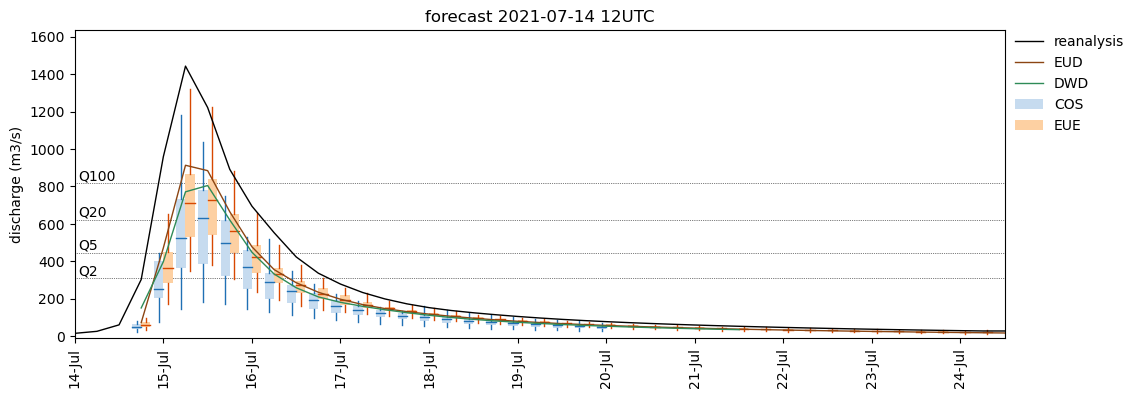

In [133]:
Qobs = Qobs.loc[start:end]

fc = datetime.strptime(forecast, '%Y%m%d%H')



st, en = fc - timedelta(days=.5), fc + timedelta(days=10)
ymax = thresholds['rl100'] * 2

# combination = 'Brier weighted'

fig, ax = plt.subplots(figsize=(12, 4))
width = .105

# reanalysis
ax.plot(Qobs, c='k', lw=1, zorder=5, label='reanalysis')

# EUD
df = dis_model['EUD'].transpose()['EUD-00']
df.index = [mdates.date2num(fc + timedelta(hours=lt)) for lt in df.index]
ax.plot(df, c='saddlebrown', lw=1, zorder=5, label='EUD')

# DWD
df = dis_model['DWD'].transpose()['DWD-00']
df.index = [mdates.date2num(fc + timedelta(hours=lt)) for lt in df.index]
ax.plot(df, c='seagreen', lw=1, zorder=5, label='DWD')


# COSMO-LEPS
for lt in dis_model['COS'].columns:
    cbox1 = plt.get_cmap('Blues')(0.25)
    cline1 = plt.get_cmap('Blues')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt - 1.25))
    ax.boxplot(dis_model['COS'][lt],
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox1, 'edgecolor': 'none'},
               medianprops={'color': cline1},
               whiskerprops={'color': cline1},
               flierprops={'markersize': 0})
        
# ECMWF-ENS
for lt in dis_model['EUE'].columns:
    cbox2 = plt.get_cmap('Oranges')(0.25)
    cline2 = plt.get_cmap('Oranges')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt + 1.25))
    ax.boxplot(dis_model['EUE'][lt],
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox2, 'edgecolor': 'none'},
               medianprops={'color': cline2},
               whiskerprops={'color': cline2},
               flierprops={'markersize': 0})

# return periods
if thresholds is not None:
    x = [0, 246]
    for rp in [2, 5, 20, 100]:
        ax.axhline(thresholds[f'rl{rp}'], color='k', ls=':', lw=.5, zorder=0)
        ax.text(st + timedelta(hours=1), thresholds[f'rl{rp}'], f'Q{rp}', ha='left', va='bottom')

# settings
xticks = pd.date_range(st, en, freq='d')
xticklabels = [x.strftime('%d-%b') for x in xticks]
ax.set(xlim=(st, en),
       # xlabel='date time',
       xticks = xticks,
       xticklabels=xticklabels,
       ylim=(-10, ymax),
       ylabel='discharge (m3/s)',
       # yticks=np.concatenate((np.zeros((1,)), thresholds.values[1:])),
       # yticklabels=[0] + ['Q' + x[2:] for x in thresholds.index[1:]],
       title='forecast ' + datetime.strptime(forecast, '%Y%m%d%H').strftime('%Y-%m-%d %HUTC'),
      )
ax.tick_params(axis='x', rotation=90)

# legend
handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor=cbox1, edgecolor='none'))
labels.append('COS')
boxplot_legend = Patch(facecolor=cbox2, edgecolor='none')
handles.append(Patch(facecolor=cbox2, edgecolor='none'))
labels.append('EUE')
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.91, .6, .1, .3]);

plt.savefig(f'NWP_{stn}_{forecast}.jpg', dpi=300, bbox_inches='tight')

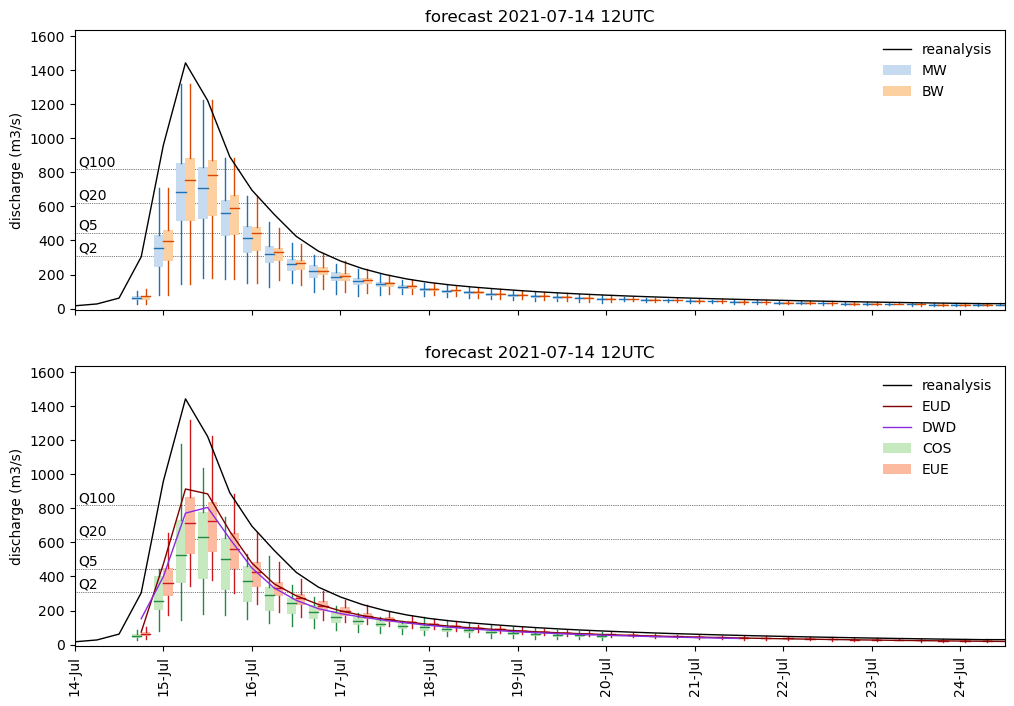

In [150]:
Qobs = Qobs.loc[start:end]
fc = datetime.strptime(forecast, '%Y%m%d%H')

st, en = fc - timedelta(days=.5), fc + timedelta(days=10)
ymax = thresholds['rl100'] * 2

# combination = 'Brier weighted'

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, sharey=True)
width = .105

# reanalysis
for ax in axes:
    ax.plot(Qobs, c='k', lw=1, zorder=5, label='reanalysis')

# forecasts
for lt in dis.columns:
    
    # MEMBER WEIGHTED
    cbox1 = plt.get_cmap('Blues')(0.25)
    cline1 = plt.get_cmap('Blues')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt - 1.25))
    axes[0].boxplot(dis[lt].dropna(),
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox1, 'edgecolor': 'none'},
               medianprops={'color': cline1},
               whiskerprops={'color': cline1},
               flierprops={'markersize': 0})
        
    # BRIER WEIGHTED
    
    # discharge values
    q = dis[lt].dropna().sort_values()
    members = q.shape[0]
    # print(lt, members)

    # weights
    w = weights_6h.sel(leadtime=lt).to_pandas()
    w = pd.Series({model: v / models[model]['members'] for model, v in w.items()})
    
    assert np.isclose(np.nansum([v * models[model]['members'] for model, v in w.items()]), 1., rtol=1e-3), 'The sum of weights is not 1'
    
    # cumulative probability of non-exceedance
    p = pd.Series([w[idx.split('-')[0]] for idx in q.index], index=q.index).cumsum()
    
    assert np.isclose(p.max(), 1., rtol=1e-3), 'The cumulative non-exceedance probability is not 1'
    
    # discharge quantiles
    idx = [(p - x).abs().idxmin() for x in [.25, .5, .75]]
    quantiles = q.loc[idx].to_list()
    # whiskers
    iqr = quantiles[2] - quantiles[0]
    lw = max(quantiles[0] - 1.5 * iqr, q.min())
    uw = min(quantiles[2] + 1.5 * iqr, q.max())

    data = [lw] + quantiles + [uw]
    cbox2 = plt.get_cmap('Oranges')(0.25)
    cline2 = plt.get_cmap('Oranges')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt + 1.25))
    axes[0].boxplot(data,
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox2, 'edgecolor': 'none'},
               medianprops={'color': cline2},
               whiskerprops={'color': cline2},
               flierprops={'markersize': 0});
    
# legend
handles, labels = axes[0].get_legend_handles_labels()
handles.append(Patch(facecolor=cbox1, edgecolor='none'))
labels.append('MW')
boxplot_legend = Patch(facecolor=cbox2, edgecolor='none')
handles.append(Patch(facecolor=cbox2, edgecolor='none'))
labels.append('BW')
axes[0].legend(handles, labels, frameon=False, loc=1);


# EUD
df = dis_model['EUD'].transpose()['EUD-00']
df.index = [mdates.date2num(fc + timedelta(hours=lt)) for lt in df.index]
axes[1].plot(df, c='maroon', lw=1, zorder=5, label='EUD')

# DWD
df = dis_model['DWD'].transpose()['DWD-00']
df.index = [mdates.date2num(fc + timedelta(hours=lt)) for lt in df.index]
axes[1].plot(df, c='blueviolet', lw=1, zorder=5, label='DWD')

# COSMO-LEPS
for lt in dis_model['COS'].columns:
    cbox1 = plt.get_cmap('Greens')(0.25)
    cline1 = plt.get_cmap('Greens')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt - 1.25))
    axes[1].boxplot(dis_model['COS'][lt],
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox1, 'edgecolor': 'none'},
               medianprops={'color': cline1},
               whiskerprops={'color': cline1},
               flierprops={'markersize': 0})
        
# ECMWF-ENS
for lt in dis_model['EUE'].columns:
    cbox2 = plt.get_cmap('Reds')(0.25)
    cline2 = plt.get_cmap('Reds')(0.75)
    pos = mdates.date2num(fc + timedelta(hours=lt + 1.25))
    axes[1].boxplot(dis_model['EUE'][lt],
               positions=[pos],
               widths=width,
               patch_artist=True,
               showcaps=False,
               boxprops={'facecolor': cbox2, 'edgecolor': 'none'},
               medianprops={'color': cline2},
               whiskerprops={'color': cline2},
               flierprops={'markersize': 0})
    
# legend
handles, labels = axes[1].get_legend_handles_labels()
handles.append(Patch(facecolor=cbox1, edgecolor='none'))
labels.append('COS')
boxplot_legend = Patch(facecolor=cbox2, edgecolor='none')
handles.append(Patch(facecolor=cbox2, edgecolor='none'))
labels.append('EUE')
axes[1].legend(handles, labels, frameon=False, loc=1);

# return periods
for ax in axes:
    if thresholds is not None:
        x = [0, 246]
        for rp in [2, 5, 20, 100]:
            ax.axhline(thresholds[f'rl{rp}'], color='k', ls=':', lw=.5, zorder=0)
            ax.text(st + timedelta(hours=1), thresholds[f'rl{rp}'], f'Q{rp}', ha='left', va='bottom')

    # settings
    xticks = pd.date_range(st, en, freq='d')
    xticklabels = [x.strftime('%d-%b') for x in xticks]
    ax.set(xlim=(st, en),
           # xlabel='date time',
           xticks = xticks,
           xticklabels=xticklabels,
           ylim=(-10, ymax),
           ylabel='discharge (m3/s)',
           # yticks=np.concatenate((np.zeros((1,)), thresholds.values[1:])),
           # yticklabels=[0] + ['Q' + x[2:] for x in thresholds.index[1:]],
           title='forecast ' + datetime.strptime(forecast, '%Y%m%d%H').strftime('%Y-%m-%d %HUTC'),
          )
    ax.tick_params(axis='x', rotation=90)


plt.savefig(f'MW_vs_BW_vs_NWP_{stn}_{forecast}.jpg', dpi=300, bbox_inches='tight')